In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [27]:
mnist_dataset = datasets.MNIST('./mnist_data', download=True, train=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=128, shuffle=True)

mnist_dataset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True)

In [15]:
class Gaussian:
    def __init__(self, mu, rho):
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(loc=0, scale=1)
        
    @property
    def sigma(self):
        return F.softplus(self.rho)
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        
        return self.mu + self.sigma * epsilon
        
    def log_likelihood(self, x):
        l1 = -np.log(np.sqrt(2 * np.pi)) 
        l2 = -torch.log(self.sigma) 
        l3 = -((x - self.mu) ** 2) / (2 * self.sigma ** 2)
        ll = (l1 + l2 + l3)

        return ll
    

In [16]:
torch.Tensor([0, 1, 2, 3]) - 3

torch.cuda.FloatTensor([0,])

tensor([0.], device='cuda:0')

In [17]:
class ScaleMixtureGaussian:
    def __init__(self, pi, sigma1, sigma2):
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0, sigma1)
        self.gaussian2 = torch.distributions.Normal(0, sigma2)
        
    def log_likelihood(self, x):
        likelihood1 = torch.exp(self.gaussian1.log_prob(x))
        likelihood2 = torch.exp(self.gaussian2.log_prob(x))
        ll = torch.log(self.pi * likelihood1 + (1 - self.pi) * likelihood2)

        return ll
    

In [22]:
class VariationalLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        # weight
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # bias
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # prior
        #self.weight_prior = ScaleMixtureGaussian(pi=0.5, sigma1=1, sigma2=np.exp(-6))
        #self.bias_prior = ScaleMixtureGaussian(pi=0.5, sigma1=1, sigma2=np.exp(-6))
        
        self.weight_prior = Gaussian(torch.cuda.FloatTensor([0]), torch.cuda.FloatTensor([1]))
        self.bias_prior = Gaussian(torch.cuda.FloatTensor([0]), torch.cuda.FloatTensor([1]))
        
    def forward(self, x, return_kl=True):
        weight_sample = self.weight.sample()
        bias_sample = self.bias.sample()
        
        y = F.linear(x, weight_sample, bias_sample)
        
        if return_kl:
            weight_prior_ll = self.weight_prior.log_likelihood(weight_sample)
            bias_prior_ll = self.bias_prior.log_likelihood(bias_sample)
            
            weight_posterior_ll = self.weight.log_likelihood(weight_sample)
            bias_posterior_ll = self.bias.log_likelihood(bias_sample)
            
            weight_kl = (weight_posterior_ll - weight_prior_ll).sum()
            bias_kl = (bias_posterior_ll - bias_prior_ll).sum()
            
            kl_divergence = weight_kl + bias_kl 
            
            return y, kl_divergence
        else:
            return y
        

In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = VariationalLinear(28 * 28, 400)
        self.linear2 = VariationalLinear(400, 400)
        self.linear3 = VariationalLinear(400, 10)
        self.cross_entropy_loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x, t):
        # x : [batch, channel=1, width=28, height=28]
        # t : [batch]
        
        kl_loss_sum = 0
        
        y = x.view(-1, 28 * 28)
        
        y, kl_loss = self.linear1(y)
        kl_loss_sum += kl_loss
        y = F.relu(y)
        
        y, kl_loss = self.linear2(y)
        kl_loss_sum += kl_loss
        y = F.relu(y)
        
        y, kl_loss = self.linear3(y)
        kl_loss_sum += kl_loss
        
        ce_loss = self.cross_entropy_loss(y, t)
        #print('ce : ', ce_loss.item())
        #print('kl : ', kl_loss_sum.item())
        total_loss = ce_loss + kl_loss_sum / x.size(0)
        
        return F.softmax(y), total_loss
        
        
    def predict(self, x):
        # [batch, channel=1, width=28, height=28]
        
        y = x.view(-1, 28 * 28)
        y = F.relu(self.linear1(y, return_kl=False))
        y = F.relu(self.linear2(y, return_kl=False))
        y = F.softmax(self.linear3(y, return_kl=False))
        
        return y
        
        

In [24]:
model = Model().to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters())
print(optimizer)

Model(
  (linear1): VariationalLinear()
  (linear2): VariationalLinear()
  (linear3): VariationalLinear()
  (cross_entropy_loss): CrossEntropyLoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


5


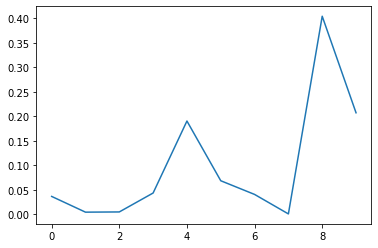

201 114.22209930419922
202 118.882080078125
203 113.97887420654297
204 117.06130981445312
205 115.63550567626953
206 114.90093231201172
207 112.27239990234375
208 119.323974609375
209 113.89569091796875
210 120.10213470458984
211 112.09308624267578
212 107.27738189697266
213 114.37763977050781
214 113.58438110351562
215 111.57987976074219
216 113.55579376220703
217 112.79358673095703
218 120.45857238769531
219 109.89527893066406
220 136.0294647216797
221 113.60005950927734
222 109.31827545166016
223 115.36837005615234
224 114.70172119140625
225 113.06987762451172
226 112.01583862304688
227 117.47425842285156
228 116.79563903808594
229 121.86618041992188
230 114.39085388183594
231 114.81044006347656
232 112.90020751953125
233 113.56828308105469
234 126.18984985351562
235 111.57564544677734
236 115.72199249267578
237 114.61565399169922
238 116.71404266357422
239 114.24954986572266
240 110.71420288085938
241 117.04082489013672
242 120.34749603271484
243 110.72673034667969
244 115.77262878

KeyboardInterrupt: 

In [83]:
from IPython import display
import matplotlib.pyplot as plt

model.train()

while(True):
    for batch_index, batch in enumerate(train_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)

        model.zero_grad()
        y, total_loss = model(x, t)

        total_loss.backward()
        optimizer.step()

        print(batch_index, total_loss.item())

        if batch_index % 100 == 0:
            display.clear_output()
            _y = y.data.cpu().numpy()
            _t = t.data.cpu().numpy()
            print(_t[0])
            plt.plot(_y[0])
            plt.show()

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


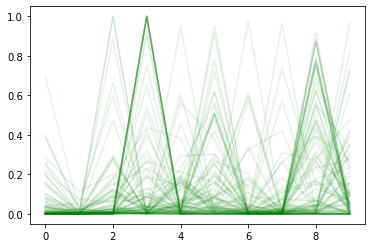

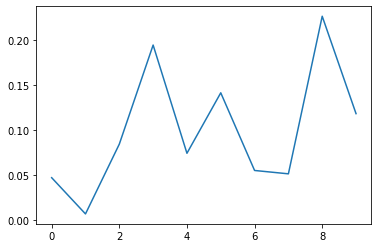

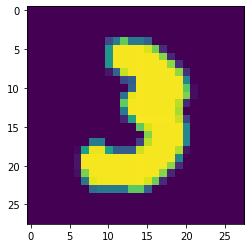

In [90]:
model.eval()

test_batch = next(iter(test_loader))

x, t = test_batch
x = x.to(DEVICE)

y_list = []
for _ in range(100):
    y = model.predict(x)
    y_list.append(y)

ys = torch.cat(y_list, dim=0)
_ys = ys.data.cpu().numpy()

for i in range(100):
    plt.plot(_ys[i], alpha=0.1, color='g')
plt.show()

_y_mean = np.mean(_ys, axis=0)
plt.plot(_y_mean)
plt.show()

_x = x.data.cpu().numpy()
plt.imshow(_x[0, 0])
plt.show()